# План домашней работы
1. Реализовать алгоритмы **item2item**, **ALS**, **IALS** (2 балл за каждый)
2. Посчитать метрику предсказаний **MAP@10** (2 балла)

Будем решать задачу предсказания: на 4/5 пользователей учимся, на 1/5 выбрасываем случайный лайк и пытаемся предсказать его беря топ 100 наших лучших предсказаний для этого пользователя.

3. Подобрать параметры алгоритмов для максимизации MAP@10 (1 балл)
4. Сравнить похожести айтемов получаюшиеся для item2item, ALS, IALS (1 балл)

Замерить насколько получаются похожими топы похожестей. Так же рекомендуется взять 5-топовых (или любимых) фильмов и посмотреть на похожести которые получаются для них в разных алгоритмах.

In [1]:
import pathlib
import warnings

import polars as pl
from hydra import initialize, compose
import hydra
import seaborn as sns
import numpy as np
from omegaconf import OmegaConf
import pandas as pd
import tqdm
import numba

In [2]:
warnings.simplefilter("ignore", tqdm.TqdmWarning, append=True)
warnings.simplefilter("ignore", numba.errors.NumbaPerformanceWarning, append=True)

In [3]:
sns.set_style("dark")

In [4]:
%load_ext autoreload
%autoreload 2

from made_recsys.matrix_ops import interactions_to_csc_matrix
from made_recsys.utils import load_pickle
from made_recsys.log_set import init_logging
from made_recsys.utils import load_pickle, load_json

In [5]:
is_init_logging = True

In [6]:
if not is_init_logging:
    init_logging("./log_settings.yaml")

In [7]:
with initialize(config_path="configs", version_base="1.3"):
    train_test_config = compose("train_test_split")

In [8]:
with initialize(config_path="configs", version_base="1.3"):
    item2item_config = compose("item2item")

In [9]:
train_data_dir = pathlib.Path(train_test_config.train_dir)
test_data_dir = pathlib.Path(train_test_config.test_dir)
dump_dir = pathlib.Path(train_test_config.dump_dir)

In [10]:
all_names = pl.read_parquet(dump_dir / "items.parquet")

In [11]:
user_encoder = load_pickle(str(train_data_dir / "user_encoder.pickle"))

In [12]:
item_encoder = load_pickle(str(train_data_dir / "item_encoder.pickle"))

In [13]:
all_names.head()

item_id,title,genres
u32,str,str
1,"""Toy Story (199…","""Animation|Chil…"
2,"""Jumanji (1995)…","""Adventure|Chil…"
3,"""Grumpier Old M…","""Comedy|Romance…"
4,"""Waiting to Exh…","""Comedy|Drama"""
5,"""Father of the …","""Comedy"""


In [14]:
len(user_encoder.classes_), len(item_encoder.classes_)

(4832, 3692)

In [15]:
train_interactions = pl.read_parquet(train_data_dir / "train.parquet")

In [16]:
user_item_inter = interactions_to_csc_matrix(train_interactions, user_encoder, item_encoder)

In [17]:
test_hist = pl.read_parquet(test_data_dir / "test_hist.parquet")
valid_inter = pl.read_parquet(test_data_dir / "test_valid.parquet")

In [18]:
top_item_ids = train_interactions.groupby("item_id").count().top_k(k=5, by="count").get_column("item_id")

In [19]:
top_item_ids

item_id
u32
2858
260
1196
1210
480


In [20]:
num_rec = train_test_config.predict_top_n

# Item2Item

## Результаты при разных параметрах

In [21]:
item2item_exp_dir = pathlib.Path("data", "item2item")

In [22]:
target_metric_name = "map"

In [23]:
hyperparams_results =  []

for entity in item2item_exp_dir.iterdir():
    if not entity.is_dir():
        continue
    config = entity / ".hydra" / "config.yaml"
    metric_file = entity / "metrics" / "map.json"
    hyperparams_results.append((OmegaConf.to_container(OmegaConf.load(config)), load_json(str(metric_file))[target_metric_name], entity))

In [24]:
item2item_params = pd.DataFrame.from_records(hyperparams_results, columns=["params", target_metric_name, "path"])
item2item_params = pd.concat(
    (
        pd.json_normalize(item2item_params["params"]), 
        item2item_params[item2item_params.columns.difference(["params"])]), axis=1)

In [25]:
item2item_params.sort_values(target_metric_name, ascending=False).style.hide(subset=["test_dir", "train_dir", "dump_dir", "path"], axis="columns")

,algo._target_,algo.seed,algo.metric,algo.max_candidates,algo.low_memory,map
1,made_recsys.item2item.Item2ItemRecommender,12123,cosine,101,False,0.023750
0,made_recsys.item2item.Item2ItemRecommender,12123,jaccard,101,False,0.020608


In [26]:
best_item2item_config, _, exp_dir = max(hyperparams_results, key=lambda x: x[1])

In [27]:
item2item_rec = hydra.utils.instantiate(best_item2item_config["algo"], user_encoder=user_encoder, item_encoder=item_encoder)

In [28]:
item2item_rec.load_index(exp_dir / best_item2item_config["dump_dir"])

# ALS

## Результаты при разных параметрах

In [29]:
als_exp_dir = pathlib.Path("data", "als")

In [30]:
hyperparams_results =  []

for entity in als_exp_dir.iterdir():
    if not entity.is_dir():
        continue
    config = entity / ".hydra" / "config.yaml"
    metric_file = entity / "metrics" / "map.json"
    hyperparams_results.append((OmegaConf.to_container(OmegaConf.load(config)), load_json(str(metric_file))[target_metric_name], entity))

In [31]:
als_params = pd.DataFrame.from_records(hyperparams_results, columns=["params", target_metric_name, "path"])
als_params = pd.concat(
    (
        pd.json_normalize(als_params["params"]), 
        als_params[als_params.columns.difference(["params"])]), axis=1)

In [32]:
als_params.sort_values(target_metric_name, ascending=False).style.hide(subset=["test_dir", "train_dir", "dump_dir", "path"], axis="columns")

,algo._target_,algo.latent_size,algo.l2_reg,algo.num_iterations,algo.seed,map
1,made_recsys.als.ALS,2,2.403958,5,12123,0.038699
8,made_recsys.als.ALS,2,2.165991,5,12123,0.037356
10,made_recsys.als.ALS,2,2.688743,5,12123,0.036910
7,made_recsys.als.ALS,2,2.000565,7,12123,0.035665
3,made_recsys.als.ALS,2,2.620018,5,12123,0.035617
27,made_recsys.als.ALS,2,2.600213,5,12123,0.035578
14,made_recsys.als.ALS,2,1.698066,5,12123,0.035333
15,made_recsys.als.ALS,2,4.895204,6,12123,0.035181
12,made_recsys.als.ALS,2,2.550307,5,12123,0.034835
29,made_recsys.als.ALS,2,1.058103,7,12123,0.034727


In [33]:
best_als_config, _, exp_dir = max(hyperparams_results, key=lambda x: x[1])

In [34]:
als = hydra.utils.instantiate(best_als_config["algo"], user_encoder=user_encoder, item_encoder=item_encoder)

In [35]:
loss_history = []

In [36]:
def loss_callback(iter, value):
    loss_history.append((iter, value))

In [37]:
als.fit(user_item_inter, loss_step_report=2, loss_callback=loss_callback, progress=True)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:07<00:00,  1.41s/it, loss=5.01e+3, loss_decreasing=578]    


In [38]:
hist = np.array(loss_history)

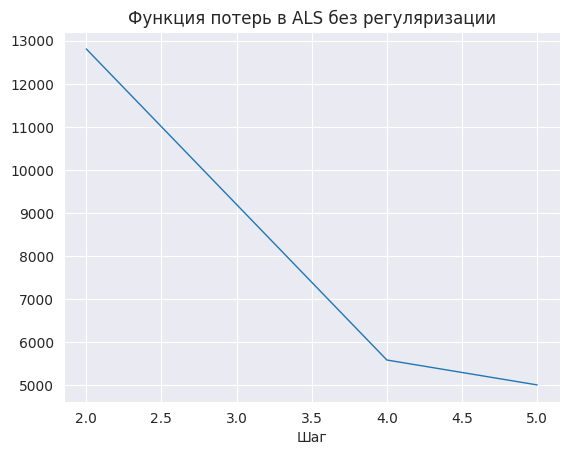

In [39]:
plot = sns.lineplot(x=hist[:, 0], y=hist[:, 1], lw=1, dashes=True)
plot.set_title("Функция потерь в ALS без регуляризации")
plot.set_xlabel("Шаг")
plot.grid(True)

# Похожести для самых популярных элементов для разных алгоритмов

In [40]:
n_sim = 5

In [41]:
item2item_sim = item2item_rec.most_similiar_items(top_item_ids, n_sim)

In [42]:
als_sim = als.most_similiar_items(top_item_ids, n_sim)

In [43]:
def add_titles(sim_item_ids: pl.DataFrame, titles: pl.DataFrame, suffix: str):
    return sim_item_ids.join(titles, on="item_id").join(titles, left_on="sim_item_id", right_on="item_id",
                                                        suffix=suffix).sort(["item_id", "distance"])

In [44]:
item2item_sim = add_titles(item2item_sim, all_names, "_item2item")

In [45]:
als_sim = add_titles(als_sim, all_names, "_als")

In [46]:
als_sim.head(n=3)

item_id,sim_item_id,distance,title,genres,title_als,genres_als
u32,u32,f32,str,str,str,str
260,673,-1.1921e-7,"""Star Wars: Epi…","""Action|Adventu…","""Space Jam (199…","""Adventure|Anim…"
260,2916,-1.1921e-7,"""Star Wars: Epi…","""Action|Adventu…","""Total Recall (…","""Action|Adventu…"
260,879,0.0,"""Star Wars: Epi…","""Action|Adventu…","""Relic, The (19…","""Horror"""


In [47]:
all_sim = item2item_sim.select(pl.col("item_id", "title", "title_item2item")).hstack(als_sim.select(pl.col("title_als")))

In [48]:
with pl.Config() as cfg:
    cfg.set_tbl_hide_dataframe_shape()
    cfg.set_fmt_str_lengths(300)
    cfg.set_tbl_formatting("UTF8_HORIZONTAL_ONLY")
    cfg.set_tbl_hide_column_data_types()
    for item_id, group in all_sim.groupby("item_id"):
        print(group)
        print("\n" * 2)

────────────────────────────────────────────────────────────────────────────────────────────────────
 item_id   title                              title_item2item                   title_als           
════════════════════════════════════════════════════════════════════════════════════════════════════
 260       Star Wars: Episode IV - A New      Star Wars: Episode V - The        Space Jam (1996)    
           Hope (1977)                        Empire Strikes Back (1980)                            
────────────────────────────────────────────────────────────────────────────────────────────────────
 260       Star Wars: Episode IV - A New      Star Wars: Episode VI - Return    Total Recall (1990) 
           Hope (1977)                        of the Jedi (1983)                                    
────────────────────────────────────────────────────────────────────────────────────────────────────
 260       Star Wars: Episode IV - A New      Raiders of the Lost Ark (1981)    Relic, The 